# Выявление профилей потребления

Интернет-магазин "Пока все ещё тут" собирается ввести интернет-рассылку покупателям с рекламными предложениями. Надо разобраться, каким покупателям стоит присылать уведомления с рекламой, какие покупатели потенциально смогут принести наибольшую прибыль.

В нашем распоряжении таблица со следующими данными:

- date - дата заказа
- customer_id - идентификатор покупателя
- order_id - идентификатор товара
- product - наименованием товара
- quantity- количество товаров в заказе
- price - цена товара

Шаги выполнения проекта:

1) Предобработка данных
 - Проанализировать таблицу, привести данные к удобному для работы формату
 - Изучить пропуски, заполнить их там, где это возможно
 - Устранить дубликаты там, где это возможно
 - Изучить наличие выбросов, исправить значения там, где это возможно

2) Анализ данных
 - На основе данных о датах заказов и распределить клиентов по группам по частоте покупок
 - На основе данных о ценах товаров, количестве товаров в заказе, а также датах заказов распределить клиентов по группам по сумме, которые они приносят от покупок
 - На основе данных о датах заказов распределить клиентов по времени, пройденному от момента их последней покупки
 - На основании этих распределений формировать сегментацию по совокупности показателей: частоты покупок, общей суммы покупок и давности покупок (согласно RFM-анализу)
 - Изучить, как товары в разрезе сегментов продавались в течение изучаемого времени
 - Изучить товары, рассмотреть, какие из них покупались клиентами из разных сегментов
 - Посмотреть, какие товары являются наиболее популярными для разных сегментов покупателей
 - Посмотреть, какие товары являются наиболее прибыльными для разных сегментов покупателей


3) Статистический анализ данных

   Проверить следующие гипотезы:
 - $H_0$: Есть статистически значимая разница в количестве товаров между группами покупателей

   $H_1$: Нет статистически значимой разницы в количестве товаров между группами покупателей


 - $H_0$: Есть статистически значимая разница в среднем чеке между группами покупателей

   $H_1$: Нет статистически значимой разницы в среднем чеке между группами покупателей


 - $H_0$: Есть статистически значимая разница в "продолжительности жизни" между группами покупателей

   $H_1$: Нет статистически значимой разницы в "продолжительности жизни" между группами покупателей


4) Сделать выводы, предоставить группу потенциально самых прибыльных клиентов

## Предобработка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import shapiro, norm
from scipy import stats as st

In [ ]:
data = pd.read_csv('/datasets/ecom_dataset_upd.csv')
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [ ]:
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Имеем таблицу с 7474 строками, пропусков нет.

Данные с датой покупки, идентификатором заказа, количеством товаров в корзине типа int, идентификатор пользователя, название продукта типа object, стоимость заказа типа float. Для удобства переведём дату в тип datetime.

In [ ]:
data['date'] = pd.to_datetime(data['date'],format='%Y%m%d%H')

data.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [ ]:
data.duplicated().sum()

0

In [ ]:
data[data[['customer_id','order_id','product','quantity','price']].duplicated()].head()

,date,customer_id,order_id,product,quantity,price
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0


Явных дубликатов нет.

Среди тех строк, у которых повторяются все столбцы, кроме даты, оставим только первые. Вероятно, у клиентов были какие-то проблемы с оплатой товара, и в логах выпадали данные о попытках сделать заказ несколько раз, поэтому в данных достаточно иметь только первые строчки.

In [ ]:
data = data.drop_duplicates(keep='first',subset=['customer_id','order_id','product','quantity','price'])

data.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Посмотрим, есть ли заказы, у которых больше одного покупателя. Если такие есть, удалим строки с номерами таких заказов.

In [ ]:
df = data.groupby('order_id')['customer_id'].nunique().reset_index()

rows_to_delete = df[df['customer_id']>1]['order_id']

data = data[~data["order_id"].isin(list(rows_to_delete))]

data.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [ ]:
data['quantity'].sort_values().unique()

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   20,   22,   23,   24,
         25,   26,   27,   29,   30,   31,   37,   40,   43,   45,   50,
         57,   59,   60,   64,   65,   70,   80,   96,  100,  140,  150,
        170,  200,  300,  334, 1000])

Некоторые данные похожи на выбросы в количестве товаров в корзине.

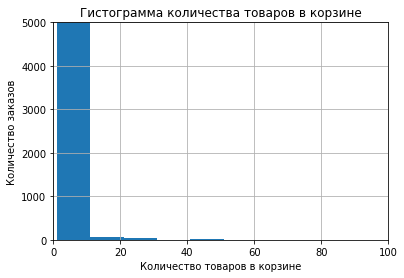

In [ ]:
plt = data['quantity'].hist(bins=100)
plt.set_xlim(0,100)
plt.set_ylim(0,5000)
plt.set_title('Гистограмма количества товаров в корзине')
plt.set_xlabel('Количество товаров в корзине')
plt.set_ylabel('Количество заказов');


Больше 4000 заказов содержат один товаров в корзине. Заказов, у которых больше товаров в корзине намного меньше.

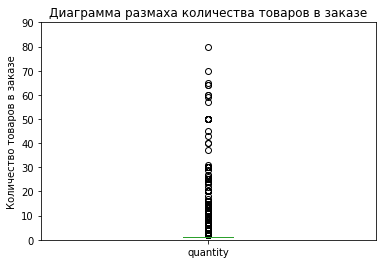

In [ ]:
plt = data['quantity'].plot.box()
plt.set_ylim([0,90])
plt.set_title('Диаграмма размаха количества товаров в заказе')
plt.set_ylabel('Количество товаров в заказе');

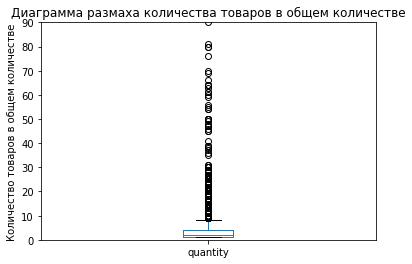

In [ ]:
plt = data.groupby('product')['quantity'].sum().plot.box()
plt.set_ylim([0,90])
plt.set_title('Диаграмма размаха количества товаров в общем количестве')
plt.set_ylabel('Количество товаров в общем количестве');

In [ ]:
print(len(data))
print(data[(data['quantity']>10)&(data['quantity']<100)][['product','quantity']].count())

display(data[(data['quantity']>10)&(data['quantity']<100)][['product','quantity']].head())

5544
product     134
quantity    134
dtype: int64


,product,quantity
13,Крючок одежный 2-х рожковый серый металлик с п...,96
42,Щетка-сметка 3-х рядная деревянная 450 мм (пло...,15
43,Щетка-сметка 4-х рядная деревянная 300 мм (фиг...,15
50,Герань домашняя (пеларгония зональная) цветуща...,11
93,"Ёрш унитазный с деревянной ручкой , Ваир 1712012",15


In [ ]:
print('Самые продаваемые товары в заказе')
display(data.sort_values(by='quantity',ascending=False)[['product','quantity']].head(10))

Самые продаваемые товары в заказе


,product,quantity
5456,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000
5071,Вешалки мягкие для деликатных вещей 3 шт шоколад,334
3961,Муляж ЯБЛОКО 9 см красное,300
1158,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200
568,Муляж ЯБЛОКО 9 см красное,170
211,"Крепеж для пружины дверной, 1107055",150
212,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150
2431,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150
586,Муляж ЯБЛОКО 9 см красное,140
1555,Щетка для мытья посуды КОЛИБРИ М5202 большая,100


In [ ]:
print('Самые продаваемые товары в общем количестве')
display(data.groupby('product')['quantity'].sum().sort_values(ascending=False).head(10))

Самые продаваемые товары в общем количестве


product
Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000                 1000
Муляж ЯБЛОКО 9 см красное                                                          618
Вешалки мягкие для деликатных вещей 3 шт шоколад                                   335
Ручка-скоба РС-100 белая *Трибатрон*, 1108035                                      201
Крепеж для пружины дверной, 1107055                                                170
Плечики пластмассовые Размер 52 - 54 Тула 1205158                                  160
Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014               150
Муляж Яблоко зеленый 9 см полиуретан                                               148
Муляж Банан желтый 21 см полиуретан                                                109
Щетка-сметка 4-х рядная деревянная 300 мм (фигурная ручка) ворс 5,5 см 1801096     105
Name: quantity, dtype: int64

По диаграмме размаха количество товаров в заказе, превышающее 1, является выбросом. Также выбросами являются количество товаров больше 20 для всего количества.

Есть товары, которые стоит покупать сразу много, поэтому не будем удалять все строки, где количество товаров больше 20. Удалим строки, в которых количество товаров больше 100.

In [ ]:
data = data.drop(data[data['quantity']==1000].index)
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [ ]:
data.to_csv(r'C:\Neuer_Ordner\ecom_csv.csv')

Разобъем товары на категории.

In [ ]:
print('Количество уникальных продуктов в продаже',data['product'].nunique())

Количество уникальных продуктов в продаже 2333


In [ ]:
data['product'] = data['product'].apply(lambda x: x.split(' ')[0]+' '+x.split(' ')[1]).str.lower()

data.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение,1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение,1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула,1,112.0


In [ ]:
list(data['product'].unique())

['комнатное растение',
 'радермахера d-12',
 'хризолидокарпус лутесценс',
 'циперус зумула',
 'шеффлера лузеана',
 'юкка нитчатая',
 'настенная сушилка',
 'таз пластмассовый',
 'чехол для',
 'вешалка для',
 'сушилка для',
 'чехол eurogold',
 'крючок одежный',
 'корзина мягкая',
 'мини-сковорода marmiton',
 'сковорода алюминиевая',
 'стеклянная крышка',
 'доска гладильная',
 'сумка-тележка 2-х',
 'многолетнее растение',
 'рассада зелени',
 'муляж "райские',
 'муляж банан,',
 'муляж виноград',
 'муляж гранат',
 'муляж груша',
 'муляж груша,',
 'муляж зеленое',
 'муляж клубника',
 'муляж красное',
 'муляж лимон,',
 'муляж мандарин,',
 'муляж перец,',
 'муляж персики',
 'муляж томат,',
 'муляж черешня',
 'щетка-сметка 3-х',
 'щетка-сметка 4-х',
 'сумка для',
 'тарелка обеденная',
 'вилка столовая',
 'ложка столовая',
 'ложка чайная',
 'нож столовый',
 'герань домашняя',
 'ерш для',
 'пеларгония зональная',
 'котел алюминиевый',
 'суккулент микс',
 'эхеверия перл',
 'набор прищепок',
 'ковр

In [ ]:
def categorize_products(row):
    if ('растение' in row or 'радермахера' in row or 'пахира' in row or 'хризолидокарпус' \
    in row or 'циперус' in row or 'шеффлера' in row or 'юкка'\
    in row or 'бархатц' in row or 'герань' in row or 'пеларгония' in row or 'суккулент' in row or\
    'эхеверия' in row or 'эвкалипт' in row or 'адиантум' in row or 'кампанула' in row or 'калатея' in row or\
    'нолина' in row or 'хлорофитум' in row or 'цикламен' in row or 'морков' in row or 'кабачок' in row or 'смолевка' in\
    row or 'глоксиния' in row or 'азалия' in row or 'гортензия' in row or 'хризантема' in row or 'мирт' in row or\
    'цветущее' in row or 'кориандр' in row or 'иссоп' in row or 'сантолина' in row or 'аспарагус' in row or 'афеляндра' in row \
    or 'антуриум' in row or 'молодило' in row or 'фиалка' in row or 'гербера' in row or 'душица' in row or 'мелисса' in\
    row or 'роза' in row or 'бегония' in row or 'розмарин' in row or 'альбука' in row or 'бальзамин' in row or 'крассула'\
    in row or 'артемизия' in row or 'лаванда' in row or 'мята' in row or 'каланхое' in row or 'спатифиллум' in row or\
    'примула' in row or 'дендробиум' in row or 'калоцефалус' in row or 'каллуна' in row or 'капсикум' in row or 'мимоза' in \
    row or 'соланум' in row or 'огурец' in row or 'алиссум' in row or 'гвоздика' in row or 'годеция' in row or 'календула'\
    in row or 'капуста' in row or 'коеопсис' in row or 'космея' in row or 'лапчатка' in row or 'львиный зев' in row or\
    'флокс' in row or 'цинерария' in row or 'эшшольция' in row or 'диффенбахия' in row or 'фаленопсис' in row or \
    'подсолнечник' in row or 'пуансетия' in row or 'гиностемма' in row or 'ель' in row or 'кипарисовик' in row or\
    'аптения' in row or 'крассула' in row or 'скиммия' in row or 'розмарин' in row or 'фиттония' in row or 'тимьян' in\
    row or 'бульонница' in row or 'алоэ' in row or 'аптения' in row or 'фикус' in row or 'фиалка' in row or 'кодонанта' in\
    row or 'гербера' in row or 'цикламен' in row or 'гимнокалициум' in row or 'примула' in row or 'калатея' in row or \
    'антириум' in row or 'эхинокактус' in row or 'эхеверия' in row or 'крокусы' in row or 'спатифиллум' in row or 'гипсофила'\
    in row or 'дендробиумы' in row or 'калибрахоа' in row or 'эпипремнум' in row or 'фаленопсис' in row or 'пуансеттия' in\
    row or 'цикламен' in row or 'хризантема' in row or 'аквилегия' in row or 'горох' in row or 'земляника' in row or \
    'незабудка' in row or 'базилик' in row or 'седум' in row or 'томат' in row or 'укроп' in row or 'нефролепис' in row or\
    'калла' in row or 'декабрист' in row or 'дендробиум' in row or 'тюльпан' in row or 'гиацинт' in row or \
    'чабер' in row or 'бакопа' in row or 'калибрахоа' in row or 'ранункулус' in row or \
    'гвоздика' in row or 'овсянница' in row or 'георгина' in row or 'календула' in row or 'космея' in row or 'цинния'\
    in row or 'базилик' in row or 'лаванда' in row or 'лавр' in row or 'вербейник' in row or 'виола' in row or 'колокольчик'\
    in row or 'котовник' in row or 'флокс' in row or 'эхинацея' in row or 'ясколка' in row or 'лилейник' in row or \
    'папоротник' in row or 'платикодон' in row or 'энотера' in row or 'фуксия' in row or 'петуния' in row or\
    'цитрофортунелла' in row or 'пеперомия' in row or 'дыня' in row or 'синнингия' in row or 'гардения' in row or \
    'лобелия' in row or 'настурция' in row or 'табак' in row or 'виноград' in row or 'вербена' in row or 'эвкалипт'\
    in row or 'мускари' in row or 'пиретрум' in row or 'агератум' in row or 'алиссум' in row or 'тагетис' in row or \
    'цинерания' in row or 'муррайя' in row or 'кореопсис' in row or 'вероника' in row or 'целозия' in row or 'арбуз' in \
    row or 'баклажан' in row or 'клубника' in row or 'патиссон' in row or 'вербена' in row or 'маттиола' in row or 'лук'\
    in row or 'джункус' in row or 'драцена' in row or 'фатсия' in row or 'хоста' in row or 'гайлардия' in row or 'монарда' \
    in row or 'нивянник' in row or 'рудбекия' in row or 'лапчатка' in row or 'седум' in row or 'бакопа' in row or 'барвинок'\
    in row or 'осина' in row or 'молодило' in row or 'сциндапсус' in row or 'травы' in row or 'аквилегия' in row or 'алиссум'\
    in row or 'астра' in row or 'бузульник' in row or 'камнеломка' in row or 'солидаго' in row or 'физостегия' in row \
    or 'бадан' in row or 'лен' in row or 'фатсия' in row or 'лантана' in row or 'лаватера' in row or 'анемона' in row or \
    'буддлея' in row or 'валериана' in row or 'змееголовник' in row or 'любисток' in row or 'монарда' in row or 'петрушка'\
    in row or 'сельдерей' in row or 'табак' in row or 'шалфей' in row or 'вигна' in row or 'тыква' in row or 'хамедорея'\
    in row or 'лантана' in row or 'зверобой' in row or 'цикламен' in row or 'мединилла' in row or 'импатиенс' in row or\
    'клен' in row or 'замиокулькас' in row or 'амариллис' in row or 'диффенбахия' in row or 'салат' in row or 'литопс' in \
    row or 'хлорофитум' in row) and ('муляж' not in row and 'салатник' not in row and 'измельчитель' not in row and 'веревка'\
                                     not in row and 'отбеливатель' not in row and 'ручка' not in row and 'простынь' not in row):
        return 'растения'

    if ('сушилка' in row or 'таз' in row or 'стеллаж' in\
    row or  'сумка' in row or 'чехол' in row or 'доска' in row or 'сумка-тележка' in row or 'ковш' in\
    row  or 'сковорода' in row or 'ерш' in row or 'ёрш' in row or 'котел' in row or 'коврик' in row or 'ковёр' in row or 'ковер'\
    in row or 'дозатор' in row or 'мусорный контейнер' in row or 'плед' in row or 'модульная' in row or 'кондиционер' in row or\
    'скатерть' in row or 'многофункциональный инструмент' in row or 'орехоколка' in row or 'термос' in row or 'мыльница' in row\
    or 'соковыжималка' in row or  'тележка' in row or 'кувшин' in row or 'стремянк' in row or 'толкушка' in row or 'простыня' in\
    row or 'чайник' in row or 'штора' in row or 'комплект' in row or 'противень' in row or 'полотенце' in row or 'миксер' in row\
    or 'кофр' in row or 'порошок' in row or 'крем' in row or 'термокружка' in row or 'кружка' in row or  'светильник' in row or \
    'жидкое мыло' in row or 'мыло' in row or 'пена' in row or 'паста' in row or 'тележка' in row or 'подрукавник' in row or 'штора'\
    in row or 'доска' in row or 'швабра' in row or 'веник' in row or 'подголовник' in row or 'короб' in row or 'наматрасник'\
    in row or 'ножеточка' in row or 'гладильная' in row or 'сиденье' in row or 'масленка' in row or 'утюг' in row or 'корыто'\
    in row or 'салатник' in row or 'урна' in row or 'чистка' in row or 'овощеварка' in row or 'сметка' in row or 'халат' in \
    row or 'тортница' in row or 'салфетница' in row or 'бензин' in row or 'фен' in row or 'лоток' in row or 'измельчитель' in\
    row or 'сушилка' in row or 'антижир' in row or 'средство' in row or 'термометр' in row or 'ножницы' in row or 'чистка' in\
    row or 'скребок' in row or 'комод' in row or 'картофелемялка' in row or 'бальзам' in row or 'рассекатель' in row or\
    'ополаскиватель' in row or 'весы' in row or 'подставка' in row or 'пресс' in row or 'подголовник' in row or 'экран'\
    in row or 'вантуз' in row or 'штопор' in row or 'блюдце' in row or 'полки' in row or 'миксер' in row or 'ключница' in\
    row or 'варка' in row or 'соль' in row or 'емкость' in row or 'гипоаллергенный' in row or 'карниз' in row or 'просеиватель'\
    in row or 'сито' in row or 'совок' in row or 'хлебница' in row or 'пылесос' in row or 'кофе' in row or 'штанга' in row or\
    'кастрюля' in row or 'миксер' in row or 'скалка' in row or 'рукав' in row or 'венчик' in row or 'бак' in row or 'миска' in\
    row or 'тортница' in row or 'блюдо' in row or 'полка' in row or 'окномойка' in row or 'кашпо' in row or 'этажерка' in row\
    or 'наматрацник' in row or 'одеяло' in row or 'тряпкодержатель' in row or 'наволочка' in row or 'обувница' in row or \
    'пододеяльник' in row or 'отжим' in row or 'покрывало' in row or 'ведро' in row or 'сотейник' in row or 'хлебница' in row \
    or 'бидон' in row or 'складной' in row or 'этажерка' in row or 'ванна' in row or 'ваза' in row or 'лоток' in row or \
    'отделитель' in row or 'измерительный' in row or 'шприц' in row or 'хлебница' in row or 'отбеливатель' in row or 'сахарница'\
    in row or 'стакан' in row or 'соковарка' in row or 'пьезозажигалка' in row or 'терка' in row or 'половник' in row or\
    'постельное' in row or 'кипятильник' in row or 'основание' in row or 'подушка' in row) and ('муляж' not in row):
        return 'хозяйственные товары'

    elif ('вешалк' in row or 'крючок' in row or 'подкладка'  in row or 'корзина'\
    in row or 'крышка' in row or 'рассада' in row or 'щетка-сметка' in row or 'щётка' in row or 'щетка' in row or 'тарелка'\
    in row or 'вилка' in row or 'ложка' in row or 'нож' in row or 'набор прищепок' in row or 'перчатки' in row or 'банка' in\
    row or 'стяжка' in row or 'набор' in row or 'плечики' in row or 'крепеж' in row or 'мешок' in row or 'уголок' in row or\
    'корзинка' in row or 'тряпка' in row or 'пружина' in row or 'петля' in row or 'салфетк' in row or 'вкладыши' in row or\
    'щетка-утюжок' in row or 'сверло' in row or 'контейнер' in row or 'карниз' in row  or 'ящик' in row or 'насадка' in row\
    or 'сварка' in row or 'шнур' in row or 'линейка' in row or 'кружка' in row or 'лопатка' in row or 'стакан' in row or\
    'насадка' in row or 'средство' in row or 'пробка' in row or 'держатель' in row or 'губка' in row or 'блок' in row or 'ролик'\
    in row or 'шило' in row or 'кисточка' in row or 'сетка' in row or 'ручка-скоба' in row or 'кольца' in row or 'фото' in\
    row or 'рамка' in row or 'картонная' in row or 'крючок' in row or 'фал капроновый' in row or 'форма alpenkok' in row or \
    'маска' in row or 'смесь' in row or 'штангенциркуль' in row or 'концентрат' in row or 'форма' in row or 'ткань' in row or\
    'прищепки' in row or 'фиксатор' in row or 'скребок' in row or 'антинакипин' in row or 'шпагат' in row or 'шнур' in row or\
    'крышка' in row or 'покрытие' in row or 'веревка' in row or 'завертка' in row or 'ручка' in row or 'решетка' in row or\
    'вакуумный' in row or 'стяжки' in row or 'шпингалет' in row) and ('муляж' not in row):
        return 'бытовые товары'

    elif 'муляж' in row or 'искусственн' in row or 'декор' in row or 'композиция' in row or 'новогоднее дерево' in row:
        return 'украшения'

In [ ]:
data['category'] = data['product'].apply(categorize_products)

data.head()

,date,customer_id,order_id,product,quantity,price,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение,1,142.0,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение,1,194.0,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12,1,112.0,растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс,1,179.0,растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула,1,112.0,растения


В одной категории находятся растения, в другое хозяйственные товары, в третьей - хозяйственные товары типа креплений, ниток; товары, которые обычно покупают сразу много. И последняя категория - муляжи, искуственные растения.

category
бытовые товары           715
растения                2539
украшения                326
хозяйственные товары    1961
Name: product, dtype: int64

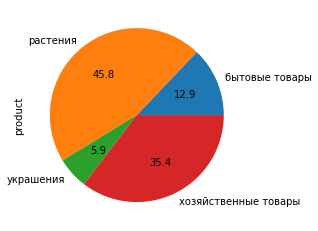

In [ ]:
display(data.groupby('category')['product'].count())
data.groupby('category')['product'].count().plot.pie(autopct='%.1f');

Больше всего покупают растений и хозяйственных товаров.

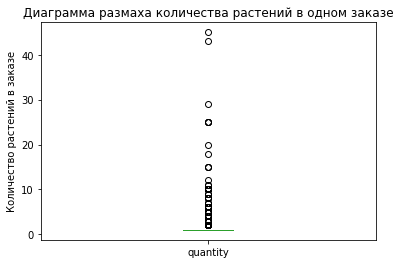

In [ ]:
plt = data[data['category']=='растения']['quantity'].plot.box()
plt.set_title('Диаграмма размаха количества растений в одном заказе')
plt.set_ylabel('Количество растений в заказе');

In [ ]:
print('Количество растений, купленных несколько за раз:',data[(data['category']=='растения')&(data['quantity']!=1)]['product'].count())

print('Количество растений, купленных в единственном экземпляре:',data[(data['category']=='растения')&(data['quantity']==1)]['product'].count())

print('Соотношение количества выбросов к количеству всех данных:', data[(data['category']=='растения')&(data['quantity']!=1)]['product'].count()/len(data))

Количество растений, купленных несколько за раз: 429
Количество растений, купленных в единственном экземпляре: 2110
Соотношение количества выбросов к количеству всех данных: 0.0773949125022551


In [ ]:
data[(data['category']=='растения')&(data['quantity']>10)].head()

,date,customer_id,order_id,product,quantity,price,category
50,2018-10-02 15:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68506,герань домашняя,11,142.0,растения
1520,2019-01-15 21:00:00,aa38e2e1-6da6-4f43-aa13-ed0210ea321c,69835,роза кустовая,25,112.0,растения
1568,2019-01-22 15:00:00,6be74251-7159-4cc0-99fb-d034a17c61b0,69928,спатифиллум шопен,45,250.0,растения
1895,2019-02-18 15:00:00,61f60726-5362-44d0-a0ae-800730389f32,70327,эхинокактус грузони,29,74.0,растения
2078,2019-03-01 10:00:00,6d78b2fa-2c18-4c59-a888-ed286e140145,14552,примула комнатная,15,98.0,растения


Некоторые растения имеет смысл покупать сразу много, например, если выращивать какие-то травяные растения, то скорее всего понадобится много семян или рассады. Цветов, например, тоже может понадобиться много, если высаживать в саду. А посколько к тому же данных не так много, не будем удалять выбросы в категории "растения".

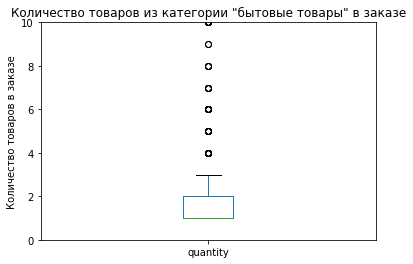

In [ ]:
plt = data[data['category']=='бытовые товары']['quantity'].plot.box()
plt.set_ylim(0,10)
plt.set_title('Количество товаров из категории "бытовые товары" в заказе')
plt.set_ylabel('Количество товаров в заказе');

In [ ]:
print('Количество товаров, купленных в нормальных количествах:',data[(data['category']=='бытовые товары')&(data['quantity']<=3)]\
      ['product'].count())

print('Количество выбросов:',data[(data['category']=='бытовые товары')&(data['quantity']>=3)]['product'].count())

print('Соотношение количества выбросов к количеству всех данных:', data[(data['category']=='бытовые товары')&(data['quantity']>3)]\
      ['product'].count()/len(data))

Количество товаров, купленных в нормальных количествах: 576
Количество выбросов: 174
Соотношение количества выбросов к количеству всех данных: 0.025076673281616453


In [ ]:
data[(data['category']=='бытовые товары')&(data['quantity']>15)].head()

,date,customer_id,order_id,product,quantity,price,category
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,крючок одежный,96,38.0,бытовые товары
144,2018-10-08 15:00:00,9151d307-654c-4239-a888-ada5ca45f0b2,68571,набор вешалок,37,202.0,бытовые товары
160,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,стяжка оконная,64,19.0,бытовые товары
164,2018-10-09 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68585,крючок одежный,25,57.0,бытовые товары
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,крепеж для,150,19.0,бытовые товары


In [ ]:
data[(data['category']=='бытовые товары')&(data['quantity']>50)].head()

,date,customer_id,order_id,product,quantity,price,category
13,2018-10-01 15:00:00,0948b0c2-990b-4a11-b835-69ac4714b21d,68486,крючок одежный,96,38.0,бытовые товары
160,2018-10-09 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68580,стяжка оконная,64,19.0,бытовые товары
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,крепеж для,150,19.0,бытовые товары
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная,150,38.0,бытовые товары
1023,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,набор ножей,64,457.0,бытовые товары


Диаграмма размаха показывает, что количество покупок для категории "крепеж" больше трех является выброом. Однако в эту категорию входит много товаров, которых логично покупать сразу много, например, крепления, вешалки и т.д., поэтому все выбросы удалять не будем, однако товары, которых купили больше 50 удалим.

In [ ]:
data = data.drop(data[(data['category']=='бытовые товары')&(data['quantity']>=50)].index)
data.head()

,date,customer_id,order_id,product,quantity,price,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение,1,142.0,растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение,1,194.0,растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12,1,112.0,растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс,1,179.0,растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула,1,112.0,растения


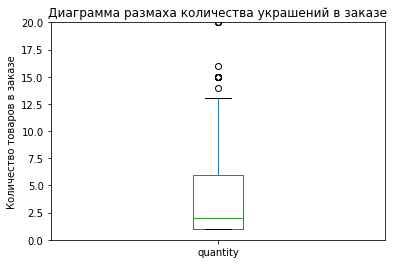

In [ ]:
plt = data[data['category']=='украшения']['quantity'].plot.box()
plt.set_ylim(0,20)
plt.set_title('Диаграмма размаха количества украшений в заказе')
plt.set_ylabel('Количество товаров в заказе');

In [ ]:
print('Количество украшений, купленных в нормальных количествах:',data[(data['category']=='украшения')\
                                                                       &(data['quantity']<15)]['product'].count())

print('Количество выбросов:',data[(data['category']=='украшения')&(data['quantity']>=15)]['product'].count())

print('Соотношение количества выбросов к количеству всех данных:', data[(data['category']=='украшения')\
                                                                        &(data['quantity']>15)]['product'].count()/len(data))

Количество украшений, купленных в нормальных количествах: 290
Количество выбросов: 36
Соотношение количества выбросов к количеству всех данных: 0.005068790731354091


In [ ]:
data[(data['category']=='украшения')&(data['quantity']>=15)].head()

,date,customer_id,order_id,product,quantity,price,category
173,2018-10-10 14:00:00,3e2c8193-3fc0-4607-a59f-bcdf169ce351,68599,муляж апельсин,25,51.0,украшения
174,2018-10-10 14:00:00,3e2c8193-3fc0-4607-a59f-bcdf169ce351,68599,муляж яблоко,25,51.0,украшения
277,2018-10-16 22:00:00,42c5db22-6046-455b-a728-ff163a1b7808,68667,муляж красное,30,19.0,украшения
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко,170,51.0,украшения
576,2018-11-01 16:00:00,fb9704c7-8106-4e7a-a2a4-70a97550deb4,68822,муляж красное,15,20.0,украшения


По диаграмме размаха выбросы для категории "украшения" начинаются с 15. Очевидных выбросов в этой категории нет, поэтому не будем ничего удалять.

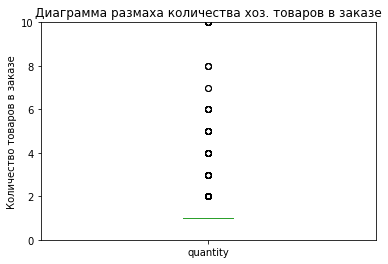

In [ ]:
plt = data[data['category']=='хозяйственные товары']['quantity'].plot.box()
plt.set_ylim(0,10)
plt.set_title('Диаграмма размаха количества хоз. товаров в заказе')
plt.set_ylabel('Количество товаров в заказе');

In [ ]:
print('Количество хозяйственных товаров, купленных в нормальных количествах:',data[(data['category']=='хозяйственные товары')\
                                                                                   &(data['quantity']==1)]['product'].count())

print('Количество выбросов:',data[(data['category']=='хозяйственные товары')&(data['quantity']!=1)]['product'].count())

print('Соотношение количества выбросов к количеству всех данных:', data[(data['category']=='хозяйственные товары')&\
                                                                        (data['quantity']!=1)]['product'].count()/len(data))


Количество хозяйственных товаров, купленных в нормальных количествах: 1701
Количество выбросов: 260
Соотношение количества выбросов к количеству всех данных: 0.04706734250543085


In [ ]:
data[(data['category']=='хозяйственные товары')&(data['quantity']>10)].head()

,date,customer_id,order_id,product,quantity,price,category
42,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,щетка-сметка 3-х,15,49.0,хозяйственные товары
43,2018-10-02 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68493,щетка-сметка 4-х,15,70.0,хозяйственные товары
93,2018-10-04 13:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68525,ёрш унитазный,15,56.0,хозяйственные товары
375,2018-10-23 11:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68727,веник сорго,17,530.0,хозяйственные товары
693,2018-11-07 19:00:00,6ae61023-9d87-4ff3-a02e-b42eab150140,68908,коврик придверный,27,286.0,хозяйственные товары


В категории "хозяйственные товары" также есть позиции, которые стоит сразу покупать много, поэтому удалять все строки с товарыми, которые купили больше 1, не стоит.

В ходе предобработки данных изучили данную таблицу на наличие пропусков, выбросов, дубликатов. На основании данных о количестве покупок разных товаров убрали выбросы.

Также разделили товары на категории.

## Анализ данных

Воспользуемся RFM-анализом для сегментации пользователей и разобъем их на группы по частоте совершения покупок, по прибыльности и давности совершения покупок.

In [ ]:
data['revenue'] = data['price']*data['quantity']
data

,date,customer_id,order_id,product,quantity,price,category,revenue
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение,1,142.0,растения,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение,1,194.0,растения,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12,1,112.0,растения,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс,1,179.0,растения,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула,1,112.0,растения,112.0
...,...,...,...,...,...,...,...,...
7469,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор),2,38.0,растения,76.0
7470,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок,1,869.0,растения,869.0
7471,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для,1,354.0,хозяйственные товары,354.0
7472,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый,1,128.0,растения,128.0


In [ ]:
data_frequency = data.groupby('customer_id')['order_id'].count().sort_values(ascending=False).reset_index()

data_frequency

,customer_id,order_id
0,c971fb21-d54c-4134-938f-16b62ee86d3b,142
1,d3b9ffea-d143-4747-8d59-74ab843d1ad6,51
2,4d93d3f6-8b24-403b-a74b-f5173e40d7db,42
3,760aa067-90c3-4794-b7a9-a8831197388b,36
4,2a0acc09-e343-4f92-b5c0-f598ef2b07d4,31
...,...,...
2395,74b08ab4-16e9-4d83-9c31-acfc9d229bc5,1
2396,749cef81-0af4-4620-b880-6a728df5dfe8,1
2397,7488ed43-43a3-4251-9606-27ab0240dc39,1
2398,745f204d-ebc7-4bd8-bfcf-f2700a0ec698,1


In [ ]:
data_value = data.groupby('customer_id')['revenue'].sum().sort_values(ascending=False).reset_index()

data_value

,customer_id,revenue
0,c971fb21-d54c-4134-938f-16b62ee86d3b,158292.0
1,58a4c3cc-504f-43ea-a74a-bae19e665552,53232.0
2,4d93d3f6-8b24-403b-a74b-f5173e40d7db,51828.0
3,6987e6d6-a63a-4ce2-a2d0-f424092d235e,32718.0
4,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,30440.0
...,...,...
2395,21df03ad-d9ac-47e9-a482-5372fd3e2464,22.0
2396,e9e94e71-4cd2-47fc-9b3f-1ec96bd2d95e,22.0
2397,f34611ba-b488-4a88-8d6b-f59a05970fc1,22.0
2398,9777b839-4212-41bb-94c2-87de3658248a,15.0


In [ ]:
max_date = data['date'].max()

data_recency = data.groupby('customer_id')['date'].max().reset_index()

data_recency['recency'] = (max_date - data_recency['date']).dt.days

data_recency.sort_values(by='recency',ascending=True)

,customer_id,date,recency
418,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,2020-01-31 02:00:00,0
2034,d99d25f1-4017-4fcd-8d29-c580cc695a1a,2020-01-30 22:00:00,0
1919,cdd17932-623e-415f-a577-3b31312fd0e2,2020-01-31 12:00:00,0
430,2e460a26-35af-453d-a369-a036e95a40e0,2020-01-31 15:00:00,0
913,63208953-a8e4-4f77-9b47-3a46e7b72eee,2020-01-30 21:00:00,0
...,...,...,...
216,17213b88-1514-47a4-b8aa-ce51378ab34e,2018-10-01 18:00:00,486
1703,b731df05-98fa-4610-8496-716ec530a02c,2018-10-01 21:00:00,486
2216,ee47d746-6d2f-4d3c-9622-c31412542920,2018-10-01 00:00:00,487
206,161e1b98-45ba-4b4e-8236-e6e3e70f6f7c,2018-10-01 11:00:00,487


In [ ]:
data1 = data_recency.merge(data_frequency,\
                           on='customer_id')
data_merged = data1.merge(data_value, on='customer_id')
data_merged

,customer_id,date,recency,order_id,revenue
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16 08:00:00,107,4,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16 11:00:00,349,1,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14 23:00:00,108,1,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27 17:00:00,368,1,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29 17:00:00,123,1,2324.0
...,...,...,...,...,...
2395,ff601403-b094-4b86-9ac6-264d725b9277,2020-01-19 11:00:00,12,2,1739.0
2396,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,2019-10-30 07:00:00,93,1,397.0
2397,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,2018-12-14 23:00:00,412,1,389.0
2398,ffb80538-3fda-4351-8ea9-9d2bec58bb07,2019-09-09 12:00:00,144,1,974.0


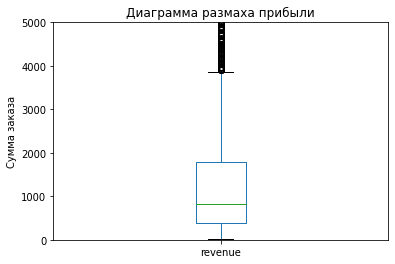

In [ ]:
plt = data_merged['revenue'].plot.box()

plt.set_ylim(0,5000)
plt.set_title('Диаграмма размаха прибыли')
plt.set_ylabel('Сумма заказа');

Обычно суммарная стоимость всех заказов была не больше 4000. Медианное значение - примерно 1000.
Пусть все покупки, которые стоили меньше первой квартили самой низкой категории, те, которые попадали в межквартильный размах - средней категории, остальные - высшей.

In [ ]:
def categorize_by_revenue(revenue):
    if revenue<400:
        return 1
    elif revenue>=400 and revenue<2000:
        return 2
    elif revenue>=2000:
        return 3
data_merged['M_rating'] = data_merged['revenue'].apply(categorize_by_revenue)

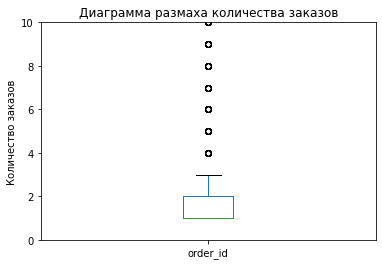

In [ ]:
plt = data_merged['order_id'].plot.box()

plt.set_ylim(0,10)
plt.set_title('Диаграмма размаха количества заказов')
plt.set_ylabel('Количество заказов');

Заказов было обычно не больше 3. Медианное значение - 2.
Пусть количество заказов, равное 1, относится к худшей категории, меньше 2 - ко второй, больше - к высшей.

In [ ]:
def categorize_by_frequency(value):
    if value==1:
        return 1
    elif value<=2:
        return 2
    elif value>=3:
        return 3
data_merged['F_rating'] = data_merged['order_id'].apply(categorize_by_frequency)
data_merged

,customer_id,date,recency,order_id,revenue,M_rating,F_rating
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16 08:00:00,107,4,555.0,2,3
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16 11:00:00,349,1,442.0,2,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14 23:00:00,108,1,914.0,2,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27 17:00:00,368,1,1649.0,2,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29 17:00:00,123,1,2324.0,3,1
...,...,...,...,...,...,...,...
2395,ff601403-b094-4b86-9ac6-264d725b9277,2020-01-19 11:00:00,12,2,1739.0,2,2
2396,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,2019-10-30 07:00:00,93,1,397.0,1,1
2397,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,2018-12-14 23:00:00,412,1,389.0,1,1
2398,ffb80538-3fda-4351-8ea9-9d2bec58bb07,2019-09-09 12:00:00,144,1,974.0,2,1


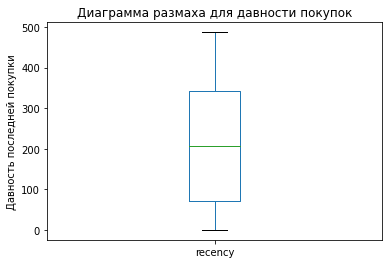

In [ ]:
plt = data_merged['recency'].plot.box()

plt.set_title('Диаграмма размаха для давности покупок')
plt.set_ylabel('Давность последней покупки');

Покупок, которым больше 500 дней, нет. Медианное значение - примерно 200.
Пусть все покупки, которые стоили меньше первой квартили самой высокой категории, те, которые попадали в межквартильный размах - средней категории, остальные - низшей.

In [ ]:
def categorize_by_recency(value):
    if value<100:
        return 3
    elif value>=100 and value<350:
        return 2
    elif value>=350:
        return 1
data_merged['R_rating'] = data_merged['recency'].apply(categorize_by_recency)
data_merged

,customer_id,date,recency,order_id,revenue,M_rating,F_rating,R_rating
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16 08:00:00,107,4,555.0,2,3,2
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16 11:00:00,349,1,442.0,2,1,2
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14 23:00:00,108,1,914.0,2,1,2
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27 17:00:00,368,1,1649.0,2,1,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29 17:00:00,123,1,2324.0,3,1,2
...,...,...,...,...,...,...,...,...
2395,ff601403-b094-4b86-9ac6-264d725b9277,2020-01-19 11:00:00,12,2,1739.0,2,2,3
2396,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,2019-10-30 07:00:00,93,1,397.0,1,1,3
2397,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,2018-12-14 23:00:00,412,1,389.0,1,1,1
2398,ffb80538-3fda-4351-8ea9-9d2bec58bb07,2019-09-09 12:00:00,144,1,974.0,2,1,2


In [ ]:
data_merged['RFM_data_score_sum'] = data_merged['R_rating']+data_merged['F_rating']+data_merged['M_rating']
data_merged['segment'] = pd.qcut(data_merged['RFM_data_score_sum'],q=4,labels=['lost_customer','low_value_customer',\
                                                                              'medium_value_customer','top_customer'])
data_merged.head()

,customer_id,date,recency,order_id,revenue,M_rating,F_rating,R_rating,RFM_data_score_sum,segment
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10-16 08:00:00,107,4,555.0,2,3,2,7,medium_value_customer
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02-16 11:00:00,349,1,442.0,2,1,2,5,low_value_customer
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10-14 23:00:00,108,1,914.0,2,1,2,5,low_value_customer
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01-27 17:00:00,368,1,1649.0,2,1,1,4,lost_customer
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09-29 17:00:00,123,1,2324.0,3,1,2,6,low_value_customer


segment
lost_customer            617
low_value_customer       940
medium_value_customer    594
top_customer             249
Name: customer_id, dtype: int64

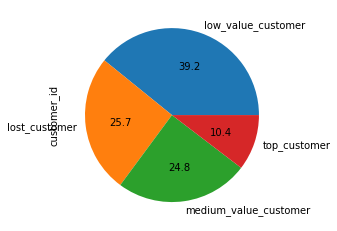

In [ ]:
display(data_merged.groupby('segment')['customer_id'].count())

data_merged.groupby('segment')['customer_id'].count().sort_values(ascending=False).plot.pie(autopct='%.1f');

Больше всего, почти 40%, пользователей категории low_value_customer. Меньше всего - top_customer, их примерно 10%.

Наибольший интерес представляют клиенты категории medium_value_customer и low_value_customer и top_customer. Клиентов первых двух категорий можно было бы попробовать завлечь, отправив им потенциально интересные предложения, а клиентов категории top_customer можно было бы поощрить какими-нибудь специальными предложениями.

In [ ]:
print('Средние прибыль и среднее количество заказов для каждого сегмента ')
data_merged.groupby('segment')['revenue'].mean().reset_index().merge(data_merged.groupby('segment')['order_id'].mean(),\
                                                                     on='segment').rename(columns={'revenue':'mean_revenue',\
                                                                                                  'order_id':\
                                                                                                   'mean_number_of_orders'})


Средние прибыль и среднее количество заказов для каждого сегмента 


,segment,mean_revenue,mean_number_of_orders
0,lost_customer,456.367909,1.022690
1,low_value_customer,1575.743262,1.639362
2,medium_value_customer,1440.077301,3.466330
3,top_customer,4691.372825,5.192771


Для топовых клиентов средняя цена заказа почти 4700, среднее количество заказов примерно 5. Наименее прибыльный сегмент - потерянные клиенты, для них цена примерно 456, и всего один заказ.

In [ ]:
print('Начало рассматриваемого периода: ',data['date'].min())
print('Конец рассматриваемого периода: ',data['date'].max())

Начало рассматриваемого периода:  2018-10-01 00:00:00
Конец рассматриваемого периода:  2020-01-31 15:00:00


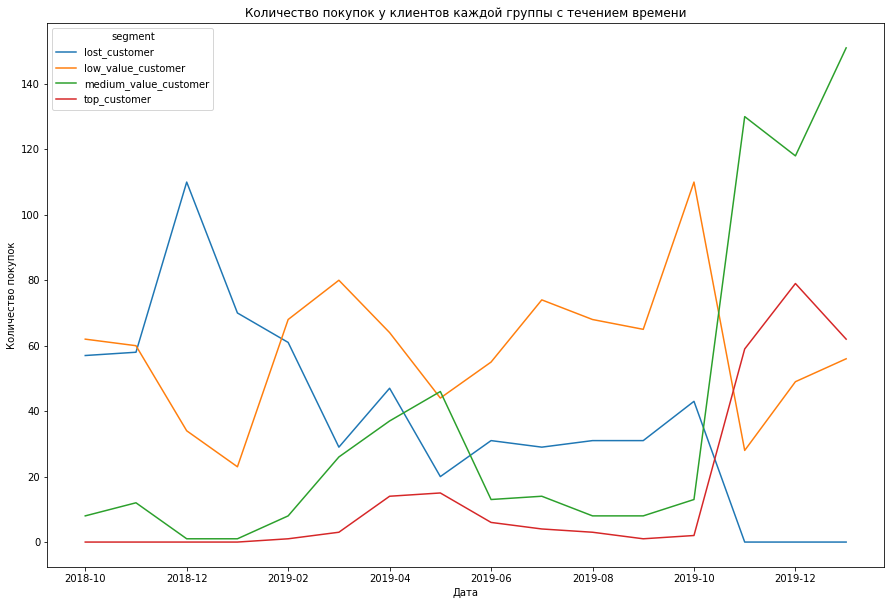

In [ ]:
data_merged['date']=pd.to_datetime(data_merged['date']).dt.strftime('%Y-%m')

plt = data_merged.pivot_table(index='segment',columns='date',values='customer_id',aggfunc='count').T.plot(figsize=(15,10))
plt.set_title('Количество покупок у клиентов каждой группы с течением времени')
plt.set_ylabel('Количество покупок')
plt.set_xlabel('Дата');

По количеству купленных товаров выделяется сегмент medium_value_customer. В конце изучаемого периода количество совершенных покупок было около 160. Также заметна группа low_value_customer, у которой был пик, достигший отметки в примерно 120 в октябре 2019-ого года.

Также видно повышение активности у групп medium_value_customer и top_customer к декабрю 2019-ого года, как и у категории lost_customer в декабре 2018. Возможно клиенты покупали чаще в декабре в связи с Новым годом.

In [ ]:
data_merged = data_merged.merge(data.groupby('customer_id')['product'].count().reset_index(),on='customer_id')
data_merged.head()


,customer_id,date,recency,order_id,revenue,M_rating,F_rating,R_rating,RFM_data_score_sum,segment,product
0,000d6849-084e-4d9f-ac03-37174eaf60c4,2019-10,107,4,555.0,2,3,2,7,medium_value_customer,4
1,001cee7f-0b29-4716-b202-0042213ab038,2019-02,349,1,442.0,2,1,2,5,low_value_customer,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,2019-10,108,1,914.0,2,1,2,5,low_value_customer,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,2019-01,368,1,1649.0,2,1,1,4,lost_customer,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2019-09,123,1,2324.0,3,1,2,6,low_value_customer,1


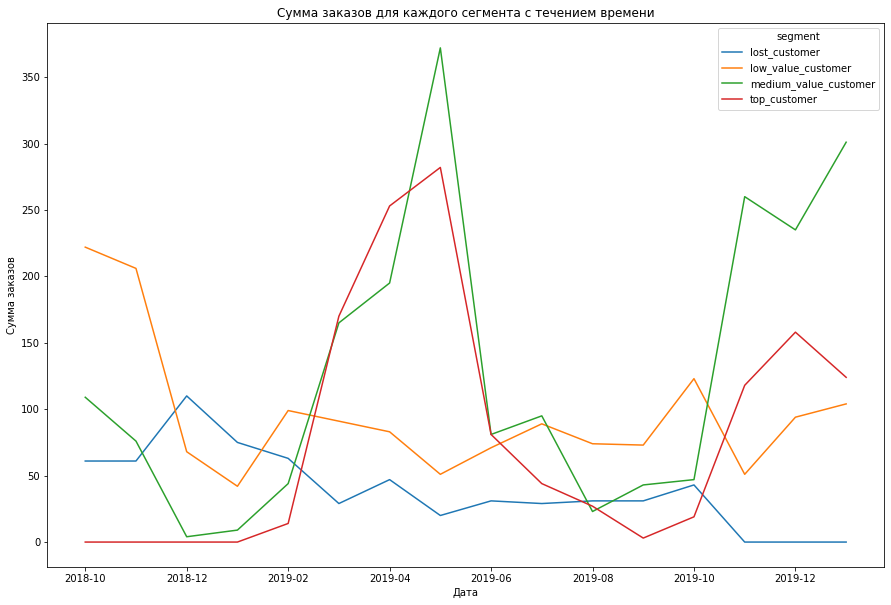

In [ ]:
plt = data_merged.pivot_table(index='segment',columns='date',values='product',aggfunc='sum').T.plot(figsize=(15,10))
plt.set_title('Сумма заказов для каждого сегмента с течением времени')
plt.set_xlabel('Дата')
plt.set_ylabel('Сумма заказов');

Виден заметный пик в апреле 2019 года для групп medium_value_customer и top_customer. Сумма заказов для этих категорий была в районе 350.

В начале изучаемого периода, в октябре 2018-ого года сегмент low_value_customer достиг своего максимума по сумме заказа в чуть больше 200 рублей, и в конце, в декабре 2019-ого сегмент medium_value_customer достиг выского значения в почти 300 рублей.

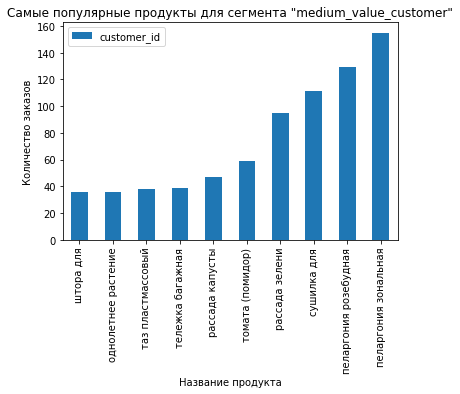

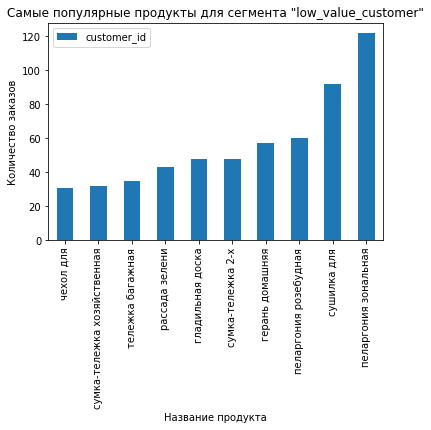

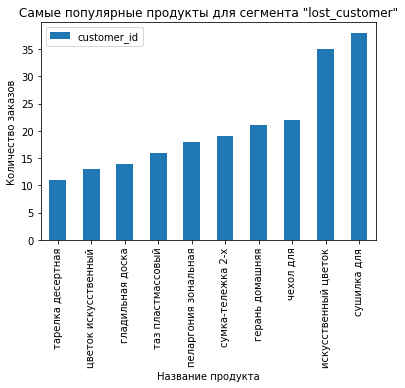

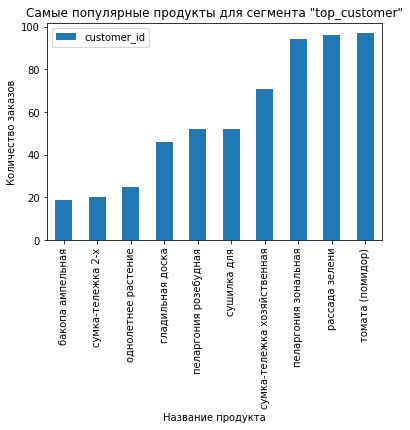

In [ ]:
for segments in list(data_merged['segment'].unique()):
    plt = data_merged[data_merged['segment']==segments]\
    ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('product')['customer_id']\
    .count().sort_values().tail(10).reset_index().plot.bar(x='product',y='customer_id',title=segments)
    plt.set_title(f'Самые популярные продукты для сегмента "{segments}"')
    plt.set_xlabel('Название продукта')
    plt.set_ylabel('Количество заказов');

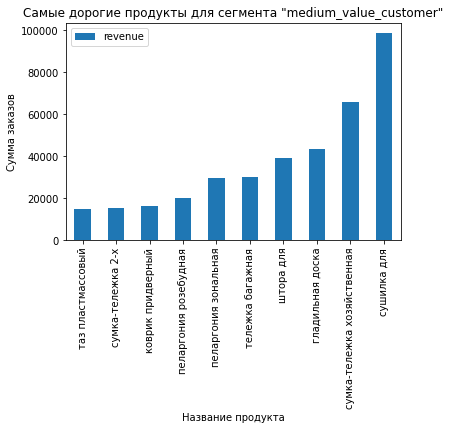

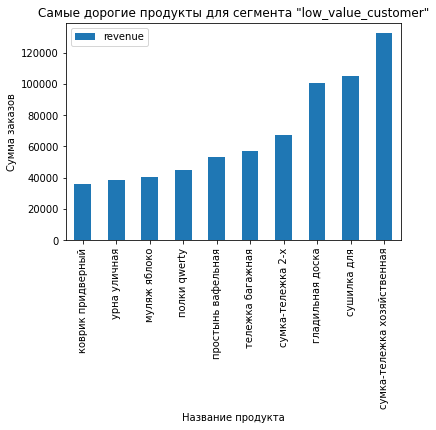

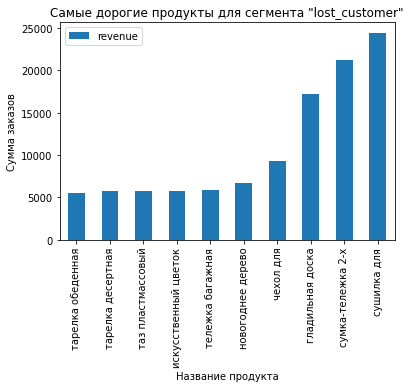

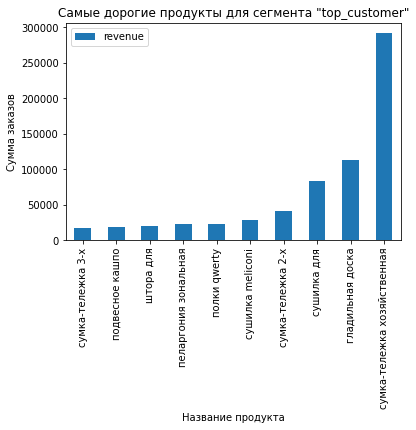

In [ ]:
for segments in list(data_merged['segment'].unique()):
    plt = data_merged[data_merged['segment']==segments]\
    ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('product')['revenue']\
    .sum().sort_values().tail(10).reset_index().plot.bar(x='product',y='revenue',title=segments)
    plt.set_title(f'Самые дорогие продукты для сегмента "{segments}"')
    plt.set_xlabel('Название продукта')
    plt.set_ylabel('Сумма заказов');

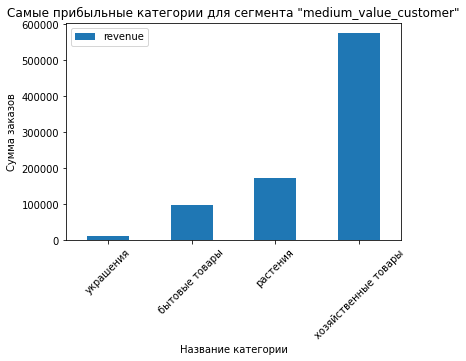

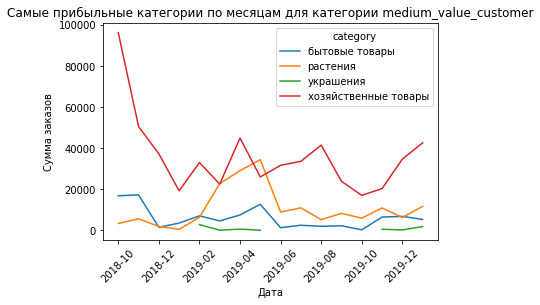

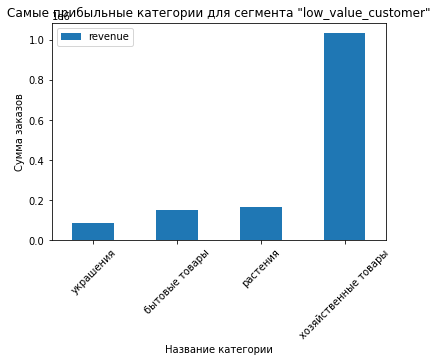

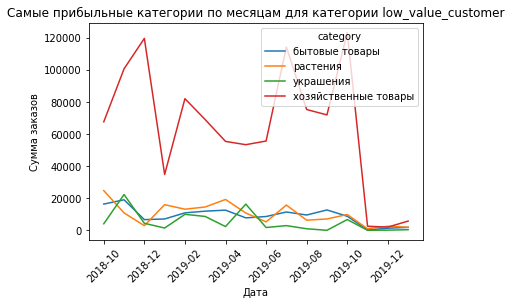

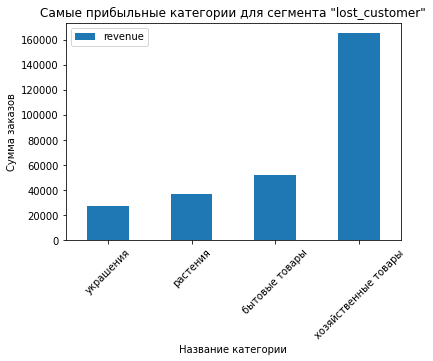

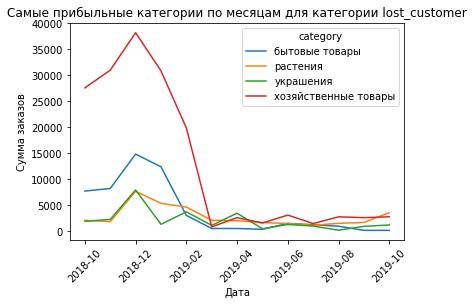

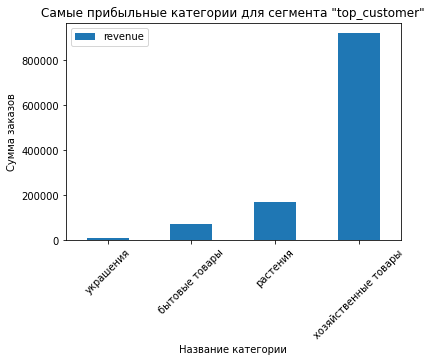

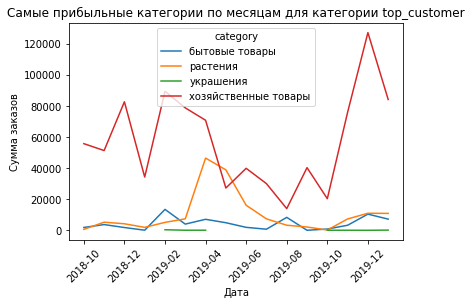

In [ ]:
for segments in list(data_merged['segment'].unique()):
    plt = data_merged[data_merged['segment']==segments]\
    ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('category')['revenue']\
    .sum().sort_values().reset_index().plot.bar(x='category',y='revenue',title=segments,rot=45)
    plt.set_title(f'Самые прибыльные категории для сегмента "{segments}"')
    plt.set_xlabel('Название категории')
    plt.set_ylabel('Сумма заказов');
    segmented_data = data_merged[data_merged['segment']==segments]['customer_id'].reset_index().\
    merge(data,on='customer_id',how='inner')
    segmented_data['date']=pd.to_datetime(segmented_data['date']).dt.strftime('%Y-%m')
    plt = segmented_data.pivot_table(index='date',columns='category',values='revenue',aggfunc='sum').plot(rot=45)
    plt.set_title(f'Самые прибыльные категории по месяцам для категории {segments}')
    plt.set_xlabel('Дата')
    plt.set_ylabel('Сумма заказов');


In [ ]:
for segments in list(data_merged['segment'].unique()):
    print(segments)
    display(data_merged[data_merged['segment']==segments]\
    ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('category')['revenue']\
    .sum().sort_values(ascending=False).reset_index())

medium_value_customer


,category,revenue
0,хозяйственные товары,574888.250000
1,растения,172019.333333
2,бытовые товары,97686.333333
3,украшения,10812.000000


low_value_customer


,category,revenue
0,хозяйственные товары,1.033603e+06
1,растения,1.629770e+05
2,бытовые товары,1.478200e+05
3,украшения,8.356667e+04


lost_customer


,category,revenue
0,хозяйственные товары,165348.0
1,бытовые товары,51963.0
2,растения,37109.0
3,украшения,27159.0


top_customer


,category,revenue
0,хозяйственные товары,922068.166667
1,растения,168128.000000
2,бытовые товары,69593.000000
3,украшения,8362.666667


Для всех сегментов самой прибыльной категорией были хоз.товары.

Заметно, что у хоз.товаров и растений для medium_value_customer, как и для top_customer, в апреле был небольшой пик. Скорее всего это связано с тем, что люди покупали рассаду и растения для того, чтобы высаживать приближающимся летом. В декабре 2019-ого года сумма на хоз.товары налача расти, в октябре 2018-ого достигался максимум.

Сезонной зависимости у сегмента low_value_customer нельзя выявить.

От сегмента lost_customer с марта 2019-ого года прибыли почти не было, что логично, так как это ушедшие клиенты.

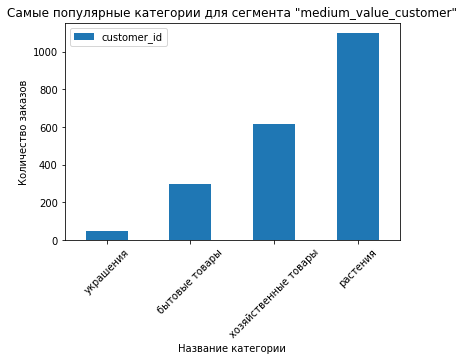

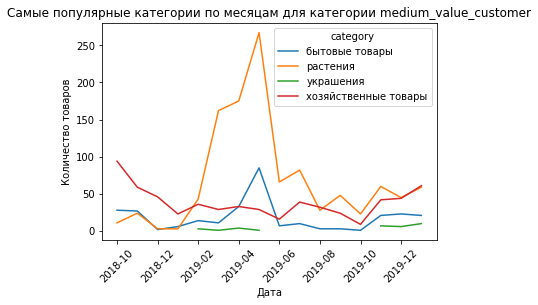

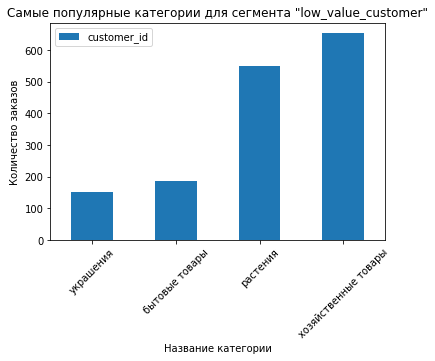

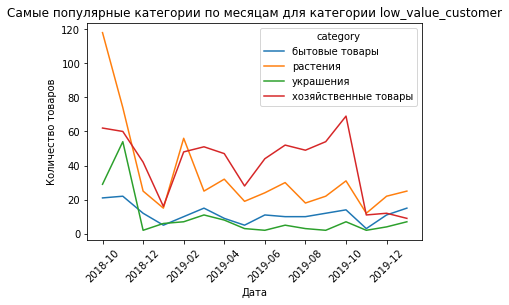

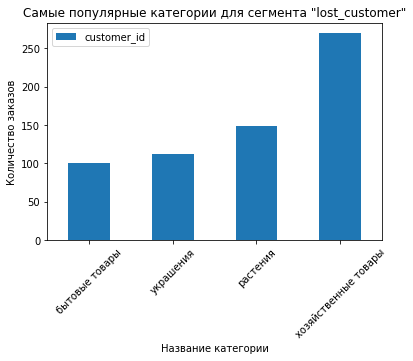

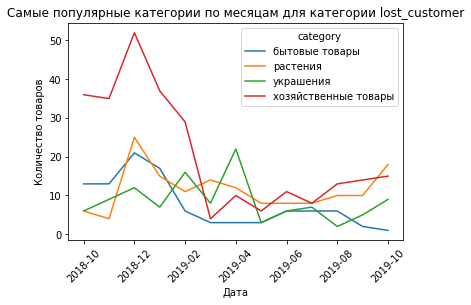

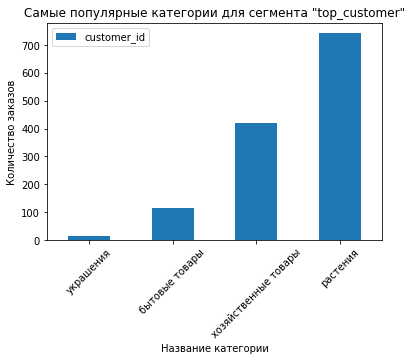

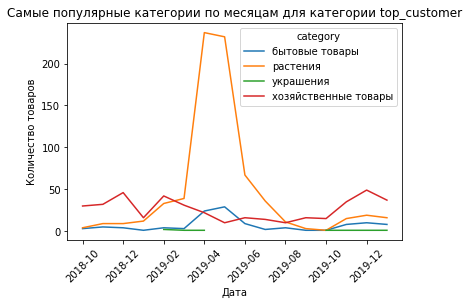

In [ ]:
for segments in list(data_merged['segment'].unique()):
    plt = data_merged[data_merged['segment']==segments]\
    ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('category')['customer_id']\
    .count().sort_values().reset_index().plot.bar(x='category',y='customer_id',title=segments,rot=45)
    plt.set_title(f'Самые популярные категории для сегмента "{segments}"')
    plt.set_xlabel('Название категории')
    plt.set_ylabel('Количество заказов')
    segmented_data = data_merged[data_merged['segment']==segments]['customer_id'].reset_index().\
    merge(data,on='customer_id',how='inner')
    segmented_data['date']=pd.to_datetime(segmented_data['date']).dt.strftime('%Y-%m')
    plt = segmented_data.pivot_table(index='date',columns='category',values='customer_id',aggfunc='count').plot(rot=45)
    plt.set_title(f'Самые популярные категории по месяцам для категории {segments}')
    plt.set_xlabel('Дата')
    plt.set_ylabel('Количество товаров');


In [ ]:
for segments in list(data_merged['segment'].unique()):
    print(segments)
    display(data_merged[data_merged['segment']==segments]\
    ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('category')['customer_id']\
    .count().sort_values(ascending=False).reset_index())

medium_value_customer


,category,customer_id
0,растения,1099
1,хозяйственные товары,616
2,бытовые товары,295
3,украшения,49


low_value_customer


,category,customer_id
0,хозяйственные товары,654
1,растения,548
2,бытовые товары,185
3,украшения,152


lost_customer


,category,customer_id
0,хозяйственные товары,270
1,растения,149
2,украшения,112
3,бытовые товары,100


top_customer


,category,customer_id
0,растения,743
1,хозяйственные товары,421
2,бытовые товары,116
3,украшения,13


Для сегментов top_customer и medium_value_customer самыми популярными категориями оказались растения. Для lost_customer и low_value_customer - хоз.товары.

Для medium_value_customer и top_customer виден большой пик в апреле для растений.

У категории low_value_customer выделяется категория хоз.товаров по количеству продаж, на протяжении всего времени она продавалась стабильно, хотя и были просадки. Для категории lost_customer количество товаров всех категорий упало в марте 2019-ого и оставалось низким до конца рассматриваемого периода.

## Проверка гипотез

$H_0$: Есть статистически значимая разница в количестве товаров между группами покупателей

$H_1$: Нет статистически значимой разницы в количестве товаров между группами покупателей

In [ ]:
alpha=0.05
'''segment_array = ['Редкие со средним чеком','Спящие разовые со средним чеком','Спящие разовые с маленьким чеком',\
                'Спящие постоянные']'''
for segments in data_merged['segment'].unique():
    stat, p = shapiro(data_merged[data_merged['segment']==segments]\
    ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('product')['customer_id']\
    .count().sort_values().tail(10).reset_index()['customer_id'])
    print(p)
    if p>alpha:
        print(f'Распределение количества товаров для группы "{segments}" нормальное')
    else:
        print(f'Распределение количества товаров для группы "{segments}" не является нормальным')


0.040012381970882416
Распределение количества товаров для группы "medium_value_customer" не является нормальным
0.026430778205394745
Распределение количества товаров для группы "low_value_customer" не является нормальным
0.06776224076747894
Распределение количества товаров для группы "lost_customer" нормальное
0.14093737304210663
Распределение количества товаров для группы "top_customer" нормальное


Будем использовать критерий Уитни для проверки гипотез, так как для многих сегментов распределение не является нормальным.

Поскольку тестов 120 для каждой гипотезы, накапливается вероятность ошибки. Поэтому применим метод Холма для поправки уровня значимости.

In [ ]:
count=0
alpha = 0.05
for j in range(len(list(data_merged['segment'].unique()))):
    for i in range(j+1,len(list(data_merged['segment'].unique()))):
        alpha=0.05/(120-count)
        count+=1
        u, p = st.mannwhitneyu(data_merged[data_merged['segment']==list(data_merged['segment'].unique())[i]]\
        ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('product')['customer_id']\
        .count().sort_values().tail(10).reset_index()['customer_id'],\
                                 data_merged[data_merged['segment']==list(data_merged['segment'].unique())[j]]\
        ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('product')['customer_id']\
        .count().sort_values().tail(10).reset_index()['customer_id'],alternative='two-sided')
        print(p)

        a1 = list(data_merged['segment'].unique())[i]
        a2 = list(data_merged['segment'].unique())[j]
        if p>alpha:
            print(f'Нет оснований отвергать нулевую гипотезу для сегментов "{a1}" и "{a2}"')

        else:
            print(f'Отвергаем нулевую гипотезу для сегментов "{a1}" и "{a2}"')


print(count)

0.4270075030844239
Нет оснований отвергать нулевую гипотезу для сегментов "low_value_customer" и "medium_value_customer"
0.00037720298789316965
Отвергаем нулевую гипотезу для сегментов "lost_customer" и "medium_value_customer"
0.4723423874468554
Нет оснований отвергать нулевую гипотезу для сегментов "top_customer" и "medium_value_customer"
0.0008728648301242148
Нет оснований отвергать нулевую гипотезу для сегментов "lost_customer" и "low_value_customer"
0.9698272930212717
Нет оснований отвергать нулевую гипотезу для сегментов "top_customer" и "low_value_customer"
0.0031742232317776954
Нет оснований отвергать нулевую гипотезу для сегментов "top_customer" и "lost_customer"
6


$H_0$: Есть статистически значимая разница в среднем чеке между группами покупателей

$H_1$: Нет статистически значимой разницы в среднем чеке между группами покупателей

In [ ]:
count=0
for j in range(len(list(data_merged['segment'].unique()))):
    for i in range(j+1,len(list(data_merged['segment'].unique()))):
        u, p = st.mannwhitneyu(data_merged[data_merged['segment']==list(data_merged['segment'].unique())[i]]\
    ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('customer_id')['revenue']\
    .mean().sort_values().tail(10).reset_index()['revenue'],\
                                 data_merged[data_merged['segment']==list(data_merged['segment'].unique())[j]]\
    ['customer_id'].reset_index().merge(data,on='customer_id',how='inner').groupby('customer_id')['revenue']\
    .mean().sort_values().tail(10).reset_index()['revenue'],alternative='two-sided')
        print('p-value',p)
        alpha=0.05/(120-count)
        count+=1
        a1 = list(data_merged['segment'].unique())[i]
        a2 = list(data_merged['segment'].unique())[j]
        if p>alpha:
            print(f'Нет оснований отвергать нулевую гипотезу для сегментов "{a1}" и "{a2}"')

        else:
            print(f'Отвергаем нулевую гипотезу для сегментов "{a1}" и "{a2}"')


p-value 0.00032983852077799353
Отвергаем нулевую гипотезу для сегментов "low_value_customer" и "medium_value_customer"
p-value 0.00016211073447401525
Отвергаем нулевую гипотезу для сегментов "lost_customer" и "medium_value_customer"
p-value 0.031209012771740218
Нет оснований отвергать нулевую гипотезу для сегментов "top_customer" и "medium_value_customer"
p-value 0.00016211073447401525
Отвергаем нулевую гипотезу для сегментов "lost_customer" и "low_value_customer"
p-value 0.00032983852077799353
Отвергаем нулевую гипотезу для сегментов "top_customer" и "low_value_customer"
p-value 0.00016211073447401525
Отвергаем нулевую гипотезу для сегментов "top_customer" и "lost_customer"


$H_0$: Есть статистически значимая разница в "продолжительности жизни" между группами покупателей

$H_1$: Нет статистически значимой разницы в "продолжительности жизни" между группами покупателей

In [ ]:
min_date = data.groupby('customer_id')['date'].first().reset_index()
min_date = min_date.rename(columns = {'date':'min_date'})

max_date = data.groupby('customer_id')['date'].last().reset_index()
max_date = max_date.rename(columns = {'date':'max_date'})

max_min_date = max_date.merge(min_date,on='customer_id',how='left')

max_min_date['lifetime'] = max_min_date['max_date']-max_min_date['min_date']

max_min_date.sort_values(by='lifetime',ascending=False)

,customer_id,max_date,min_date,lifetime
947,6644e5b4-9934-4863-9778-aaa125207701,2019-10-31 16:00:00,2018-10-01 08:00:00,395 days 08:00:00
1237,86432d8d-b706-463b-bd5d-6a9e170daee3,2019-10-31 19:00:00,2018-10-01 12:00:00,395 days 07:00:00
1520,a576fa59-7b28-4a4c-a496-92f128754a94,2019-10-31 19:00:00,2018-10-01 16:00:00,395 days 03:00:00
679,494a90f5-2198-4212-8fc9-e3e22ad7afd9,2019-10-31 21:00:00,2018-10-02 15:00:00,394 days 06:00:00
1762,bc7795fc-dbe8-44db-ad28-e0b75d86dabd,2019-11-01 09:00:00,2018-10-04 00:00:00,393 days 09:00:00
...,...,...,...,...
974,6a2bdd04-7d99-4f78-8bce-e7b37bb7abbb,2019-10-16 11:00:00,2019-10-16 11:00:00,0 days 00:00:00
971,69cf691b-a6c2-4543-aa8a-8cf42fe4a76e,2019-03-01 20:00:00,2019-03-01 20:00:00,0 days 00:00:00
970,69c524f1-dd2a-4c4e-a5b0-def54dc96f9e,2019-10-19 21:00:00,2019-10-19 21:00:00,0 days 00:00:00
969,69b17a52-a59b-4656-8d47-375e81e7d5f1,2019-04-30 11:00:00,2019-04-30 11:00:00,0 days 00:00:00


In [ ]:
count=0
for j in range(len(list(data_merged['segment'].unique()))):
    for i in range(j+1,len(list(data_merged['segment'].unique()))):
        u, p = st.mannwhitneyu(data_merged[data_merged['segment']==list(data_merged['segment'].unique())[i]]['customer_id'].reset_index().\
merge(max_min_date,on='customer_id',how='inner')['lifetime'],\
                                 data_merged[data_merged['segment']==list(data_merged['segment'].unique())[j]]['customer_id'].reset_index().\
merge(max_min_date,on='customer_id',how='inner')['lifetime'],alternative='two-sided')
        print('p-value',p)
        alpha=0.05/(120-count)
        count+=1
        a1 = list(data_merged['segment'].unique())[i]
        a2 = list(data_merged['segment'].unique())[j]
        if p>alpha:
            print(f'Нет оснований отвергать нулевую гипотезу для сегментов "{a1}" и "{a2}"')
        else:
            print(f'Отвергаем нулевую гипотезу для сегментов "{a1}" и "{a2}"')

p-value 2.12880600069735e-109
Отвергаем нулевую гипотезу для сегментов "low_value_customer" и "medium_value_customer"
p-value 5.110519392716369e-149
Отвергаем нулевую гипотезу для сегментов "lost_customer" и "medium_value_customer"
p-value 0.0004861018279672904
Нет оснований отвергать нулевую гипотезу для сегментов "top_customer" и "medium_value_customer"
p-value 1.0498582811840784e-30
Отвергаем нулевую гипотезу для сегментов "lost_customer" и "low_value_customer"
p-value 2.066192377857402e-102
Отвергаем нулевую гипотезу для сегментов "top_customer" и "low_value_customer"
p-value 3.100113413079454e-154
Отвергаем нулевую гипотезу для сегментов "top_customer" и "lost_customer"


Каждый тест показал, что для не для всех групп есть статистически значимая разница в среднем чеке, в количестве товаров и в продолжительности жизни. Но поскольку некоторые группы различаются только одним параметром, то стоит ожидать, что не для всех групп разница в проверяемых показателях будет статистически значимой.

Ссылка на презентацию: https://disk.yandex.ru/i/wxBuVMgU-IpmaA




## Выводы
В ходе исследования были анализированы данные о покупках в интернет-магазине "Пока все ещё тут" и выявлены следующие закономерности:

1) Обычно клиенты тратили суммарно от примерно 500 до почти 4000 рублей на все покупки. Медианное значение - примерно 1000

2) Большинство клиентов совершало не больше 3 покупок, чаще всего совершали 2 покупки.

3) Самым старым покупкам примерно 500 дней, есть покупки, которые были совершены в последний день изучаемого периода. Медианное значение давности покупок - примерно 200 дней.

4) Самыми популярными категориями товаров являются ратения и хозяйственные товары

5) Разделили клиентов на 4 категории: лучших клиентов, которые покупают часто, на большие суммы и регулярно, потерянные клиенты, клиенты, от которых низкая и средняя прибыль. Больше всего клиентов, от которых низкая прибыль. Меньше всего топовых клиентов.

6) По количеству покупок выделяется группа клиентов, от которых маленькая и средняя прибыли.

7) По сумме заказа выделяются топовые клиенты и клиенты, от которых средняя прибыль.

8) Самыми популярными и самыми прибыльными категориями товаров для всех групп явлюятся растения и хозяйственные товары.

По количеству купленных товаров выделяется сегмент medium_value_customer. В конце изучаемого периода количество совершенных покупок было около 160. Также заметна группа low_value_customer, у которой был пик, достигший отметки в примерно 120 в октябре 2019-ого года.

Также видно повышение активности у групп medium_value_customer и top_customer к декабрю 2019-ого года, как и у категории lost_customer в декабре 2018.

Виден заметный пик в апреле 2019 года для групп medium_value_customer и top_customer. Сумма заказов для этих категорий была в районе 350.

В начале изучаемого периода, в октябре 2018-ого года сегмент low_value_customer достиг своего максимума по сумме заказа в чуть больше 200 рублей, и в конце, в декабре 2019-ого сегмент medium_value_customer достиг выского значения в почти 300 рублей.

Для клиентов из групп top_customer и medium_value_customer видны небольшие пики в апреле, и заметен рост количества покупок в декабре. Скорее всего это связано с приближением времени, когда надо высаживать цветы и с приходом праздников. Вероятно, этим клиентам было бы полезно присылать рассылку с идеями для подарков на Новый год, а также предложения с растениями для высадки или удобрениями и т.д.

У клиентов сегмента low_value_customer нельзя выявить сезонность. Судя по данным, они обычно покупают хоз.товары в относительно стабильных количествах на протяжении всего года. Возможно, им было бы полезно направить рекомендации с товарами данной категории.
